In [1]:
import osm2geojson
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely import from_wkt,Point,wkt,LineString,geometry
import momepy
import numpy as np
import random
from sklearn.neighbors import KDTree
from datetime import datetime
import json



c:\Users\Viktor\OneDrive - ITMO UNIVERSITY\Studies\НИР\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#запись графа дорог в файл
def write_to_gdf(G, name, folder="scenario results/geolayers/", time=""):
    gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
    if time != "":
        today_str = f"_{time}"
    gdf_edges.to_file(f"{folder}e_{name}{today_str}.geojson", driver='GeoJSON')
    gdf_nodes.to_file(f"{folder}n_{name}{today_str}.geojson", driver='GeoJSON')

In [3]:
is_read_from_osm = False #флаг, указывающий на чтение из OSM по osm_id, иначе из файлов связей и узлов в папке presets/{filename}.geojson
graph_name = "1111192" #Выкса из OSM
graph_name = "1_Base" #Выкса из файла (название файлов без n_ e_ и .geojson). Чтение из папки net

#кол-во марщрутов для генерации
AGENTS_COUNT = 6000

#значение пропускной способности для одной полосы движения
ONE_CAPACITY = 1000

#коэффициент изменения пропускной способности полосы, при общем кол-ве полос в ребре
LANES_COEF = {
    1: 1.0,
    2: 0.95,
    3: 0.90,
    4: 0.86,
    5: 0.84,
}

### 2. Чтение графа

In [ ]:
# чтение из geojson файлов
def get_graph_from_gjson(filename):
    # загрузка GeoDataFrames из GeoJSON-файлов
    gdf_nodes = gpd.read_file(f'data/n_{filename}.geojson')
    gdf_edges = gpd.read_file(f'data/e_{filename}.geojson')

    # проверка и подготовка индексов (если нужно)
    if not isinstance(gdf_nodes.index.name, str) or gdf_nodes.index.name != 'osmid':
        gdf_nodes = gdf_nodes.set_index('osmid')
        
    if not isinstance(gdf_edges.index, pd.MultiIndex):
        gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])

    # преобразование в граф
    G = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges)

    return G

# чтение из графа OSM
def get_graph_from_osm(city_osm_id):
    osm_id = "R" + city_osm_id 
    territory = ox.geocode_to_gdf([osm_id], by_osmid=True)
    return ox.graph_from_polygon(territory.unary_union, network_type='drive_service')

Skipping field highway: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5


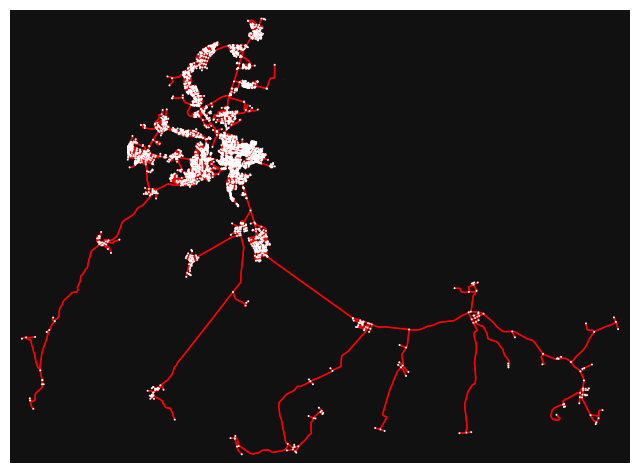

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
#чтение графа из OSM или из файла
if is_read_from_osm: 
    routes_graph = get_graph_from_osm(graph_name)
else:
    routes_graph = get_graph_from_gjson(f"{graph_name}")

today = datetime.now()
today = f"{today.day} {today.month} {today.year} - {today.hour} {today.minute} {today.second}"
ox.plot_graph(routes_graph, edge_color='r', dpi=300, save=True, filepath=f"{graph_name}-{today}.png", node_size=2)

### 3. Предварительная подготовка графа

In [6]:
#расчёт пропускной способности относительно кол-ва полос
def get_capacity_by_lanes(lanes):
    capacity = ONE_CAPACITY * LANES_COEF[lanes] * lanes
    return capacity

# Добавление полей lanes
for u, v, data in routes_graph.edges(data=True):
    if 'lanes' in data: 
        lanes = int(data['lanes']) 
        data['lanes'] = lanes
        if lanes is None:
            data["lanes"] = 1    
            print("denoning") 
    else: 
        lanes = 1
        data["lanes"] = lanes
        print ("add lanes")

oneway_routes_graph = routes_graph.copy()

rid = 0   
for u, v, data in oneway_routes_graph.edges(data=True):   
    #при наличии несольких полос в ребре выбирает наименьшее
    lanes = data["lanes"]
    if isinstance(lanes, list):
            print ("list:", lanes)
            lanes = min(lanes)
            print ("one:", lanes)
    lanes = float(lanes)
    print (lanes)

    #добавление новый полей
    data["intensity"] = 0    
    capacity = get_capacity_by_lanes(data["lanes"])
    data["capacity"] = capacity

add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes
add lanes


In [7]:
for _,__, data in oneway_routes_graph.edges(data=True):
    lanes = data["lanes"]
    print(f"{data} {lanes}")

{'osmid': '183384464', 'ref': '22К-0040', 'oneway': False, 'reversed': 'True', 'length': 86.89945815400434, 'geometry': <LINESTRING (42.163 55.366, 42.163 55.367)>, 'lanes': 1, 'intensity': 0, 'capacity': 1000.0} 1
{'osmid': '498756446', 'oneway': True, 'reversed': 'False', 'length': 198.96015866771904, 'geometry': <LINESTRING (42.163 55.366, 42.164 55.366, 42.164 55.366, 42.164 55.366, 42....>, 'lanes': 1, 'intensity': 0, 'capacity': 1000.0} 1
{'osmid': '183384464', 'ref': '22К-0040', 'oneway': False, 'reversed': 'False', 'length': 130.6131189802527, 'geometry': <LINESTRING (42.163 55.366, 42.163 55.365, 42.163 55.365, 42.163 55.365)>, 'lanes': 1, 'intensity': 0, 'capacity': 1000.0} 1
{'osmid': '183384464', 'ref': '22К-0040', 'oneway': False, 'reversed': 'False', 'length': 86.89945815400434, 'geometry': <LINESTRING (42.163 55.367, 42.163 55.366)>, 'lanes': 1, 'intensity': 0, 'capacity': 1000.0} 1
{'osmid': '183384464', 'ref': '22К-0040', 'oneway': False, 'reversed': 'True', 'length': 

### 4.	Расчёт вероятностей узлов

In [10]:
def calculate_density_probabilities(coords, radius=0.01, min_prob=0.001):
    # Преобразуем координаты в numpy массив
    points = np.array(coords)
    
    # Построение KD-дерево для эффективного поиска соседей
    tree = KDTree(points)
    
    # Для каждой точки находится количество соседей в заданном радиусе
    counts = np.array([len(tree.query_radius([point], r=radius)[0]) for point in points])
    
    # Добавление минимальную вероятность, чтобы избежать нулевых значений
    weights = counts + min_prob * len(coords)
    
    # Нормализация веса в вероятности (сумма = 1)
    probabilities = weights / weights.sum()
    
    return probabilities

#создание и заполнение массивов для id узлов и для координат узлов  
nodes_id_list = []
nodes_coordinate_list = []
for _, data in oneway_routes_graph.nodes(data=True):
    nodes_id_list.append(_)
    nodes_coordinate_list.append((data['x'], data['y']))

probabilities = calculate_density_probabilities(nodes_coordinate_list)
print(f"Кол-во узлов: {len(nodes_id_list)}. Кол-во значений вероятностей {len(probabilities)}")

Кол-во узлов: 4130. Кол-во значений вероятностей 4130


### 5.	Генерация пар точек начала и конца маршрута

In [11]:
def generate_random_points(original_points, probabilities, total_points):
    # Проверка входных данных
    if len(original_points) != len(probabilities):
        raise ValueError("Количество точек и вероятностей должно совпадать")
    if not np.isclose(sum(probabilities), 1.0):
        raise ValueError("Сумма вероятностей должна быть равна 1")
    
    # Генерация индексов исходных точек согласно вероятностям
    chosen_indices = np.random.choice(len(original_points), size=total_points, p=probabilities)
    
    # Создание листа точек путешествий
    new_points = [original_points[i] for i in chosen_indices]
    
    return new_points


#генерация массивов начальных и конечных точек маршрутов
random_points_start = generate_random_points(nodes_id_list, probabilities, AGENTS_COUNT)
random_points_end = generate_random_points(nodes_id_list, probabilities, AGENTS_COUNT)

len(random_points_end)

6000

### 6.	Построение маршрутов между точками активностей

In [12]:
def get_route(G, origin_point, destination_point):
    # Нахождение ближайших узлов (nodes) к начальной и конечной точкам
    origin_node = ox.distance.nearest_nodes(G, origin_point['x'], origin_point['y'])
    destination_node = ox.distance.nearest_nodes(G, destination_point['x'], destination_point['y'])

    # Нахождение кратчайшего пути
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    return route

#соединение начальной и конечной точки маршрутов в пары
travels = [(random_points_start[node_i], random_points_end[node_i]) for node_i in range(AGENTS_COUNT)]
count = 0

#создание временного графа для построения маршрута
G_routing = oneway_routes_graph.copy()
for points in travels:
    #построение маршрута по графу
    route = get_route(G_routing, G_routing.nodes[points[0]], G_routing.nodes[points[1]])

    #перебор всех узлов, встречающихся на маршруте
    for end_node_i in range(1, len(route)):
        #узлы текущего ребра
        u = route[end_node_i - 1]
        v = route[end_node_i]

        #увкличение счётчика интенсивности
        G_routing[u][v] [0]['intensity'] += 1 
        oneway_routes_graph[u][v] [0]['intensity'] += 1 

        #расчёт LL текущего ребра
        load_level = 1.0 * G_routing[u][v] [0]["intensity"] / G_routing[u][v] [0]["capacity"]
        
        #удаление перегруженных ребёр из временно графа
        if load_level > 1:
            G_routing.remove_edge(u,v)
    count += 1

    #обработано маршрутов:
    print(f"{count}/{AGENTS_COUNT}")
    

1/6000
2/6000
3/6000
4/6000
5/6000
6/6000
7/6000
8/6000
9/6000
10/6000
11/6000
12/6000
13/6000
14/6000
15/6000
16/6000
17/6000
18/6000
19/6000
20/6000
21/6000
22/6000
23/6000
24/6000
25/6000
26/6000
27/6000
28/6000
29/6000
30/6000
31/6000
32/6000
33/6000
34/6000
35/6000
36/6000
37/6000
38/6000
39/6000
40/6000
41/6000
42/6000
43/6000
44/6000
45/6000
46/6000
47/6000
48/6000
49/6000
50/6000
51/6000
52/6000
53/6000
54/6000
55/6000
56/6000
57/6000
58/6000
59/6000
60/6000
61/6000
62/6000
63/6000
64/6000
65/6000
66/6000
67/6000
68/6000
69/6000
70/6000
71/6000
72/6000
73/6000
74/6000
75/6000
76/6000
77/6000
78/6000
79/6000
80/6000
81/6000
82/6000
83/6000
84/6000
85/6000
86/6000
87/6000
88/6000
89/6000
90/6000
91/6000
92/6000
93/6000
94/6000
95/6000
96/6000
97/6000
98/6000
99/6000
100/6000
101/6000
102/6000
103/6000
104/6000
105/6000
106/6000
107/6000
108/6000
109/6000
110/6000
111/6000
112/6000
113/6000
114/6000
115/6000
116/6000
117/6000
118/6000
119/6000
120/6000
121/6000
122/6000
123/6000
1

### 7.	Расчёт уровня загрузки линков

In [13]:
for u, v, data in oneway_routes_graph.edges(data=True):     
    #расчёт уровня загрузки
    data["load_level"] = 1.0 * data["intensity"] / data["capacity"]

    #расчёт цвета ребра относительно LL для картограммы
    if data["load_level"] > 1:
        data["ll_color"] = '#%02x%02x%02x' % (250, 0, 0) 
    else:
        if data["load_level"] > 0.5:
            data["ll_color"] = '#%02x%02x%02x' % (255, int(255 - (data['load_level'] - 0.5) / 0.5 * 255), 0)
        else:
            data["ll_color"] = '#%02x%02x%02x' % (int(data['load_level'] * 2 * 255), 255, 0)


#расчитанный уровнень загрузки
[data["load_level"] for u, v, data in oneway_routes_graph.edges(data=True)]         

[0.391,
 0.0,
 0.363,
 0.363,
 0.391,
 0.391,
 0.0,
 0.364,
 0.427,
 0.0,
 0.402,
 0.402,
 0.001,
 0.428,
 0.001,
 0.0,
 0.003,
 0.403,
 0.0,
 0.0,
 0.425,
 0.441,
 0.459,
 0.001,
 0.003,
 0.44,
 0.462,
 0.441,
 0.458,
 0.0,
 0.028,
 0.614,
 0.602,
 0.01,
 0.017,
 0.024,
 0.618,
 0.631,
 0.001,
 0.11,
 0.588,
 0.738,
 0.036,
 0.342,
 0.265,
 0.082,
 0.08,
 0.049,
 0.063,
 0.074,
 0.215,
 0.3,
 0.059,
 0.263,
 0.311,
 0.027,
 0.217,
 0.016,
 0.232,
 0.027,
 0.001,
 0.074,
 0.445,
 0.015,
 0.09,
 0.228,
 0.013,
 0.373,
 0.241,
 0.258,
 0.026,
 0.456,
 0.077,
 0.227,
 0.615,
 0.021,
 0.007,
 0.231,
 0.259,
 0.001,
 0.003,
 0.181,
 0.146,
 0.003,
 0.003,
 0.0,
 0.151,
 0.182,
 0.0,
 0.006,
 0.177,
 0.14,
 0.0,
 0.015,
 0.028,
 0.0,
 0.0,
 0.001,
 0.027,
 0.0,
 0.015,
 0.015,
 0.029,
 0.0,
 0.0005263157894736842,
 0.005,
 0.0005263157894736842,
 0.002105263157894737,
 0.0,
 0.001,
 0.006,
 0.0,
 0.011,
 0.098,
 0.033,
 0.123,
 0.011,
 0.01,
 0.0,
 0.075,
 0.105,
 0.022,
 0.027,
 0.005,
 0.0

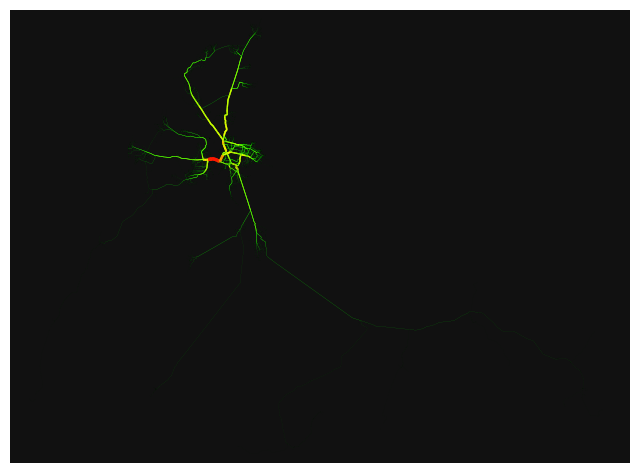

In [14]:
#генерации даты и времени создания файла
today = datetime.now()
today_str = f"{today.year}{today.month}{today.day}-{today.hour}-{today.minute}-{today.second}"

#генерация картограммы
ox.plot_graph(oneway_routes_graph, edge_linewidth= [1.0 * data['intensity'] / 400  for u, v, data in oneway_routes_graph.edges(data=True)], edge_color=[data['ll_color']  for u, v, data in oneway_routes_graph.edges(data=True)], dpi=1800, save=True, filepath=f"results/{graph_name}-load_level_{today_str}.png", node_size=0)

#генерация геослоёв
write_to_gdf(oneway_routes_graph, graph_name, "results/geo/", today_str)